# Polychromatic light in a 4f system

Notebook uses scikit-image and tqdm libraries, which can be installed using the command:

`pip install scikit-image tqdm`


In [ ]:
import torch
import torchoptics
import matplotlib.pyplot as plt
import skimage  # scikit-image

from torchoptics import Field, System, visualize_tensor
from torchoptics.elements import Lens
from tqdm import tqdm

In [ ]:
# Set simulation properties
shape = 1000  # Number of grid points in each dimension
spacing = 10e-6  # Spacing between grid points (m)
lens_wavelength = 700e-9  # Lens wavelength (m)
focal_length = 200e-3  # Lens focal length (m)

# Determine device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Configure torchoptics default properties
torchoptics.set_default_spacing(spacing)

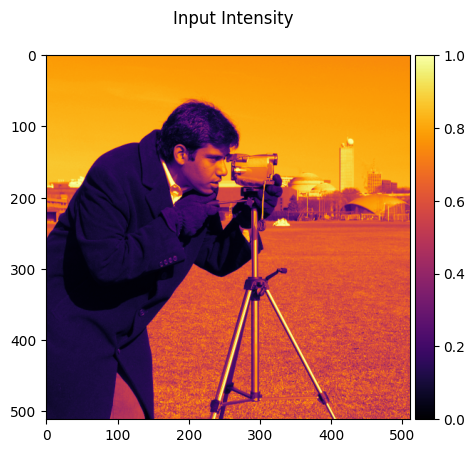

In [ ]:
# Initialize the field using the camera image from scikit-image
skimage_data = torch.tensor(skimage.data.camera())
field_data = (skimage_data / 255).sqrt()  # Normalize data to [0, 1] and use square root for field amplitude
visualize_tensor(field_data.square(), title="Input Intensity")  # Visualize the input intensity

In [ ]:
# Define 4f optical system with two lenses
system = System(
    Lens(shape, focal_length, z=1 * focal_length),
    Lens(shape, focal_length, z=3 * focal_length),
).to(device)

In [ ]:
# Initialize the optical spectrum and corresponding input fields
spectrum_wavelengths = torch.linspace(575e-9, 825e-9, 251)
input_fields = [Field(field_data, wavelength=w).to(device) for w in spectrum_wavelengths]

# Propagate the input fields through the optical system
output_fields = []
for input_field in tqdm(input_fields):
    output_fields.append(system.measure_at_z(input_field, 4 * focal_length))
output_intensities = torch.stack([f.intensity() for f in output_fields])

100%|██████████| 251/251 [04:06<00:00,  1.02it/s]


In [ ]:
def gaussian_fwhm(x, mu, fwhm):
    # Gaussian function with full width at half maximum (FWHM) parameter
    sigma = fwhm / (2 * torch.sqrt(2 * torch.log(torch.tensor(2.0))))
    norm_factor = 1 / (sigma * (2 * torch.pi) ** 0.5)
    return norm_factor * torch.exp(-((x - mu) ** 2) / (2 * sigma**2))

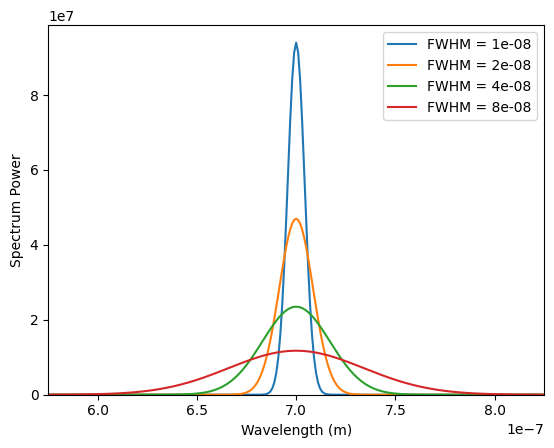

In [ ]:
# Initialize the spectrum power for different full width at half maximum (FWHM) values
fwhm_list = [10e-9, 20e-9, 40e-9, 80e-9]
spectrum_power_list = [gaussian_fwhm(spectrum_wavelengths, 700e-9, fwhm) for fwhm in fwhm_list]

# Plot the spectrum power for different FWHM values
for fwhm, spectrum_power in zip(fwhm_list, spectrum_power_list):
    plt.plot(spectrum_wavelengths, spectrum_power, label=f"FWHM = {fwhm}")
plt.xlabel("Wavelength (m)")
plt.ylabel("Spectrum Power")
plt.xlim(min(spectrum_wavelengths), max(spectrum_wavelengths))
plt.ylim(0)
plt.legend()

The incoherent output intensity of a 4f system with polychromatic light is determined by summing the individual intensities corresponding to each wavelength:

$I(r) = \int |\psi(r, \lambda) |^2 \mathrm{d} \lambda \approx \sum_i |\psi(r, \lambda_i) |^2 \Delta \lambda $


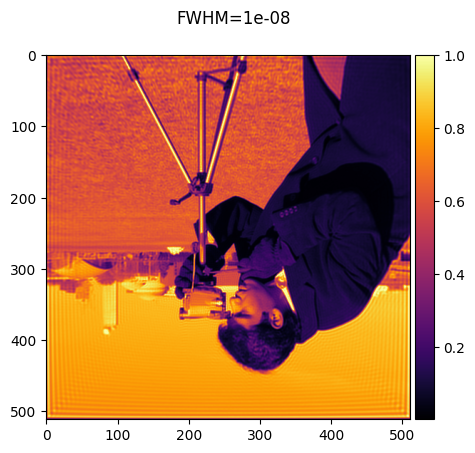

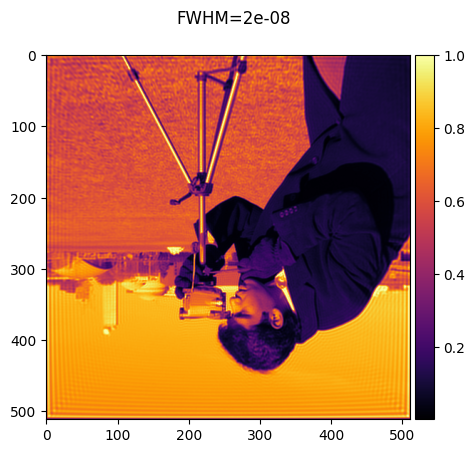

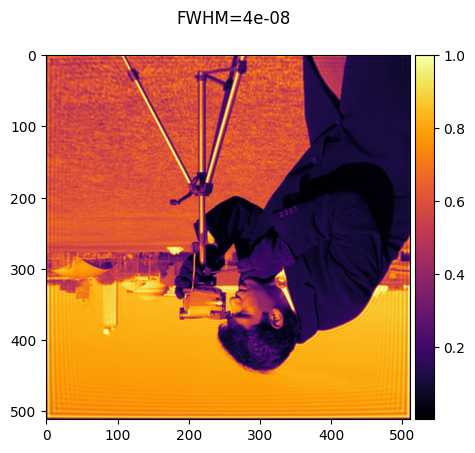

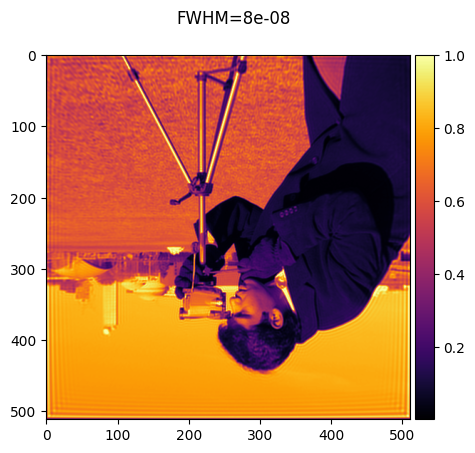

In [ ]:
d_wavelength = spectrum_wavelengths[1] - spectrum_wavelengths[0]
for spectrum_power, fwhm in zip(spectrum_power_list, fwhm_list):
    spectrum_power_unsqueezed = spectrum_power[:, None, None].to(device)
    incoherent_intensity = torch.sum(output_intensities * spectrum_power_unsqueezed, dim=0) * d_wavelength
    visualize_tensor(incoherent_intensity, title=f"FWHM={fwhm}", vmax=1)